In [1]:
%%capture
!pip install datasets

In [2]:
from datasets import load_dataset

toxic = load_dataset('csv', data_files="/content/drive/MyDrive/Scripts/365 Days Of Bert/Day17.1/train (2).csv")
toxic

Generating train split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16800
    })
})

In [3]:
toxic = toxic['train'].train_test_split(test_size=0.1)
toxic

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 15120
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 1680
    })
})

In [4]:
train_ds = toxic['train']
train_ds[0]

{'text': 'Merendeiras da rede municipal de ensino de Mafra receberam formação em Boas Práticas de Manipulação de Alimentos 🍌🍞🍛🥬🍪🥑🍰🥤🍳🍇\n\nAcesse: (link: https://t.co/Z7WSy8rVOa) https://t.co/Z7WSy8rVOa https://t.co/oHFgi5anqB',
 'label': 0}

In [5]:
train_ds.column_names

['text', 'label']

In [6]:
print(train_ds.features)

{'text': Value(dtype='string', id=None), 'label': Value(dtype='int64', id=None)}


In [7]:
import pandas as pd

toxic.set_format(type="pandas")
df = toxic["train"][:]
df.head()

,text,label
0,Merendeiras da rede municipal de ensino de Maf...,0
1,não sei se compro uma calça ou vou com a roupa...,1
2,@user e um nojo essa mulherzinha..🤢,1
3,Bolsonaro e sua corja moldam a verdade a sua m...,1
4,o menino q eu gosto nao fala cmg a quase um me...,1


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15120 entries, 0 to 15119
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    15120 non-null  object
 1   label   15120 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 236.4+ KB


I had to manually define the labels, based on this topic: https://github.com/nlp-with-transformers/notebooks/issues/131

In [9]:
# Manually define the mapping from int to str`
label_mapping = {
    0: "Non-Toxic",
    1: "Toxic",
}

# Function to convert label integer to string
def label_int2str(label):
    return label_mapping[label]

# Apply the function to the label column
df["label_name"] = df["label"].apply(label_int2str)
df.head()

,text,label,label_name
0,Merendeiras da rede municipal de ensino de Maf...,0,Non-Toxic
1,não sei se compro uma calça ou vou com a roupa...,1,Toxic
2,@user e um nojo essa mulherzinha..🤢,1,Toxic
3,Bolsonaro e sua corja moldam a verdade a sua m...,1,Toxic
4,o menino q eu gosto nao fala cmg a quase um me...,1,Toxic


In [10]:
import re

def preprocessor(text):
    text = re.sub('<[^>]*>', '', text)
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)',
                           text)
    text = (re.sub('[\W]+', ' ', text.lower()) +
            ' '.join(emoticons).replace('-', ''))
    return text



df['text'] = df['text'].apply(preprocessor)
df

,text,label,label_name
0,merendeiras da rede municipal de ensino de maf...,0,Non-Toxic
1,não sei se compro uma calça ou vou com a roupa...,1,Toxic
2,user e um nojo essa mulherzinha,1,Toxic
3,bolsonaro e sua corja moldam a verdade a sua m...,1,Toxic
4,o menino q eu gosto nao fala cmg a quase um me...,1,Toxic
...,...,...,...
15115,rt user e quando o jimin fingiu abrir a porta ...,0,Non-Toxic
15116,ai vai toma no cu moro eu fico indignada quand...,1,Toxic
15117,nicole me manda áudio ai ela falando que sempr...,0,Non-Toxic
15118,que ódio do estagiário do spfc toda hora me as...,1,Toxic


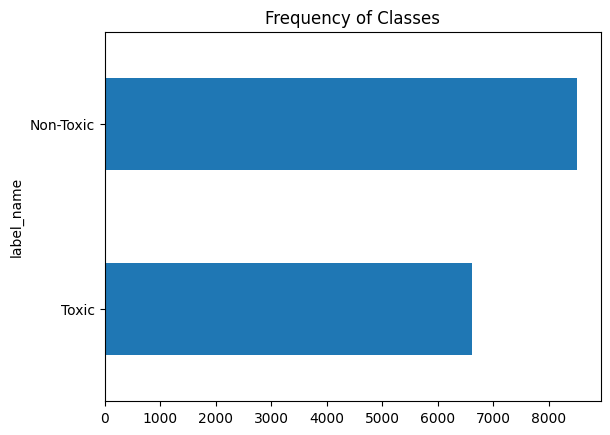

In [11]:
import matplotlib.pyplot as plt

df["label_name"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()

In [12]:
toxic.reset_format()
toxic

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 15120
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 1680
    })
})

In [13]:
from transformers import AutoTokenizer

model_ckpt = "google-bert/bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [14]:
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

toxic_encoded = toxic.map(tokenize, batched=True, batch_size=None)
toxic_encoded['train']

Map:   0%|          | 0/15120 [00:00<?, ? examples/s]

Map:   0%|          | 0/1680 [00:00<?, ? examples/s]

Dataset({
    features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 15120
})

In [15]:
import torch
from transformers import AutoModel

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [16]:
def extract_hidden_states(batch):
    inputs = {k:v.to(device) for k,v in batch.items() if k in tokenizer.model_input_names}
    # Extract last hidden states

    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state

    return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}


toxic_encoded.set_format("torch", columns=["input_ids", "attention_mask", "label"])

In [17]:
toxic_hidden = toxic_encoded.map(extract_hidden_states, batched=True)

Map:   0%|          | 0/15120 [00:00<?, ? examples/s]

Map:   0%|          | 0/1680 [00:00<?, ? examples/s]

In [19]:
import numpy as np

X_train = np.array(toxic_hidden["train"]["hidden_state"])
X_valid = np.array(toxic_hidden["test"]["hidden_state"])
y_train = np.array(toxic_hidden["train"]["label"])
y_valid = np.array(toxic_hidden["test"]["label"])
X_train.shape, X_valid.shape

((15120, 768), (1680, 768))

In [30]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

models = {
    'Logistic Regression': LogisticRegression(max_iter=300000),
    'Random Forest': RandomForestClassifier(),
    'SVM': SVC(),
    'KNN': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier()
}

for name, model in models.items():
    model.fit(X_train, y_train)
    train_score = model.score(X_train, y_train)
    test_score = model.score(X_valid, y_valid)
    print(f'{name}: train: {train_score:.4f}, test: {test_score:.4f}')


Logistic Regression: train: 0.6890, test: 0.6673
Random Forest: train: 0.9977, test: 0.6030
SVM: train: 0.6651, test: 0.6405
KNN: train: 0.7265, test: 0.5738
Decision Tree: train: 0.9977, test: 0.5595
